In [15]:
import os
os.makedirs("assets", exist_ok=True)


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)

LOCATION = "Main"


# Data Visualization Clinic — Library Circulation

**Purpose:** Demonstrate a reusable “viz clinic” workflow for consultations:  
*question framing → bad chart → improved chart → stakeholder interpretation → next actions.*

**Data:** Synthetic circulation + holds data (24 months), no PII.


In [17]:
items = pd.read_csv("data/items.csv")
patrons = pd.read_csv("data/patrons.csv")
txns = pd.read_csv("data/txns.csv", parse_dates=["checkout_dt","due_dt","return_dt"])
holds = pd.read_csv("data/holds.csv", parse_dates=["request_dt","fulfill_dt"])

# recompute flags
txns["is_returned"] = txns["return_dt"].notna()
txns["is_late"] = txns["is_returned"] & (txns["return_dt"] > txns["due_dt"])
txns["late_days"] = np.where(txns["is_late"], (txns["return_dt"] - txns["due_dt"]).dt.days, 0)

fulfilled = holds[holds["status"].eq("fulfilled")].copy()



## Executive Snapshot (KPIs)
This section provides a quick overview before diving into clinic cases.


In [18]:
kpi = pd.Series({
    "transactions": len(txns),
    "unique_patrons": txns["patron_id"].nunique(),
    "late_rate": float(txns["is_late"].mean()),
    "renew_rate": float((txns["renewal_count"] > 0).mean()),
    "not_returned_rate": float((~txns["is_returned"]).mean()),
})
kpi


transactions         20000.00000
unique_patrons        2996.00000
late_rate                0.12490
renew_rate               0.59525
not_returned_rate        0.02090
dtype: float64

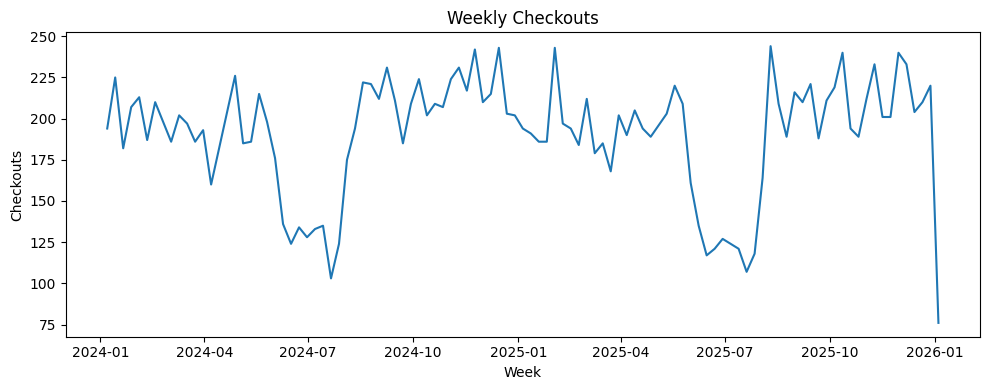

In [19]:
weekly = (
    txns.groupby(pd.Grouper(key="checkout_dt", freq="W"))
        .size().rename("checkouts")
        .reset_index()
)

plt.figure()
plt.plot(weekly["checkout_dt"], weekly["checkouts"])
plt.title("Weekly Checkouts")
plt.xlabel("Week")
plt.ylabel("Checkouts")
plt.tight_layout()
plt.show()


We can see there is an obvious drop from May to June because of summer vacation.

## Clinic #1 — Hold Wait Time: Average hides the long tail

**Bad metric:** average wait time looks acceptable, but hides tail pain.  
**Better metrics:** median + p90/p95 + peak vs off-peak comparison.


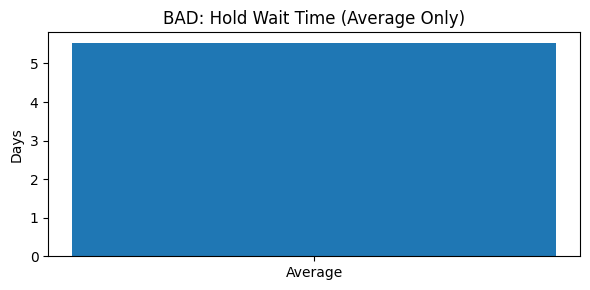

np.float64(5.530317212688507)

In [20]:
avg_wait = fulfilled["wait_days"].mean()

plt.figure(figsize=(6,3))
plt.bar(["Average"], [avg_wait])
plt.title("BAD: Hold Wait Time (Average Only)")
plt.ylabel("Days")
plt.tight_layout()
plt.show()

avg_wait


In [21]:
summary = fulfilled["wait_days"].quantile([0.5, 0.9, 0.95]).rename({0.5:"median",0.9:"p90",0.95:"p95"})
summary["max"] = fulfilled["wait_days"].max()
summary


median     5.1
p90        8.6
p95       10.1
max       19.9
Name: wait_days, dtype: float64

Half of all holds are fulfilled in ~5 days or less. This is your “typical user experience.”

90% of holds are fulfilled within ~8.6 days. Only 10% wait longer.

95% of holds are fulfilled within ~10.1 days. Only 5% wait longer.

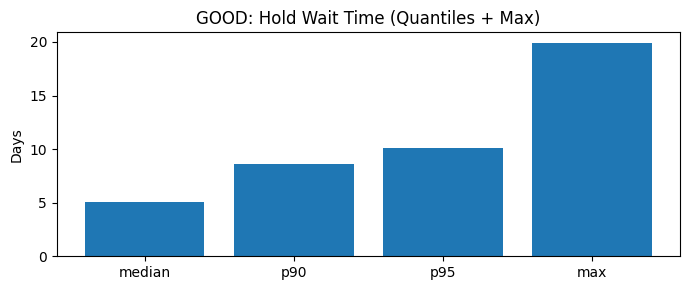

In [22]:
plt.figure(figsize=(7,3))
plt.bar(summary.index, summary.values)
plt.title("GOOD: Hold Wait Time (Quantiles + Max)")
plt.ylabel("Days")
plt.tight_layout()
plt.show()


p90 (90th percentile): 90% of appointments wait ≤ this value; only 10% wait longer.

p95 (95th percentile): 95% of appointment wait times ≤ this value; only 5% wait longer

In [23]:
fulfilled["month"] = fulfilled["request_dt"].dt.month
fulfilled["season"] = np.where(fulfilled["month"].isin([8,9,10,11,12,1,2,3,4,5]), "semester_peak", "summer_offpeak")

season_kpi = fulfilled.groupby("season")["wait_days"].agg(
    count="count",
    median="median",
    p90=lambda s: s.quantile(0.90),
    p95=lambda s: s.quantile(0.95),
    max="max"
).round(2)

season_kpi


,count,median,p90,p95,max
season,,,,,
semester_peak,1701,5.3,8.8,10.3,19.9
summer_offpeak,222,3.3,6.6,7.9,14.0


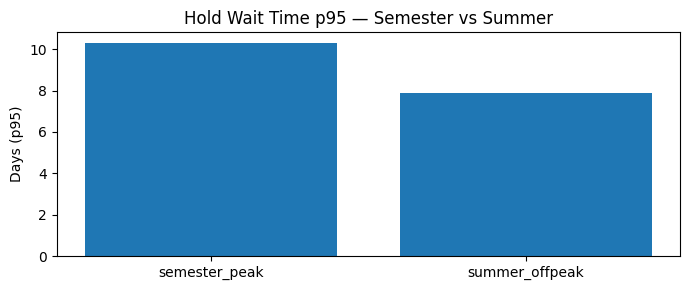

In [24]:
plt.figure(figsize=(7,3))
plt.bar(season_kpi.index, season_kpi["p95"])
plt.title("Hold Wait Time p95 — Semester vs Summer")
plt.ylabel("Days (p95)")
plt.tight_layout()
plt.show()


Peak term increases both median and tail (p95), indicating the limitation of capacity or workflow. 

**Action ideas:**  
- Track p90/p95 as service-level indicators, not averages only.  
- Review peak-term staffing or workflows and reserve availability.  
- Proactive messaging for long-wait requests.


## Clinic #2 — Late Returns: From a single rate to actionable segments
Overall late rate hides which segments drive impact. We segment by patron group × collection.


In [25]:
late_pivot = (txns
    .groupby(["patron_group","collection"])
    .agg(transactions=("txn_id","count"), late_rate=("is_late","mean"))
    .reset_index()
)
late_pivot["risk_score"] = late_pivot["transactions"] * late_pivot["late_rate"]
late_pivot["late_rate"] = late_pivot["late_rate"].round(3)

heat = late_pivot.pivot(index="patron_group", columns="collection", values="late_rate")
heat


collection,Book,CourseReserve,DVD,Laptop
patron_group,,,,
Community,0.164,0.164,0.148,0.186
Faculty,0.118,0.138,0.131,0.188
Grad,0.127,0.095,0.158,0.133
Staff,0.112,0.164,0.093,0.109
Undergrad,0.123,0.128,0.114,0.100


**Prioritization logic:** focus on segments with large *impact* (transactions × late_rate), not only high rates.

**Action ideas:**  
- High-volume segments (e.g., Undergrad/Grad × Book): due-date reminders + renewal nudges.  
- High-risk segments (e.g., Community × Book): clearer policy onboarding + FAQs.  
- High-value assets (e.g., Laptop): earlier reminders / stricter workflow safeguards.


## Reusable Clinic Template (for future consultations)

1) Clarify stakeholder question  
2) Identify a “bad chart” failure mode  
3) Produce an improved chart with an interpretation paragraph  
4) Provide 2–3 actionable next steps  
5) Package as a shareable artifact (notebook + PNGs)


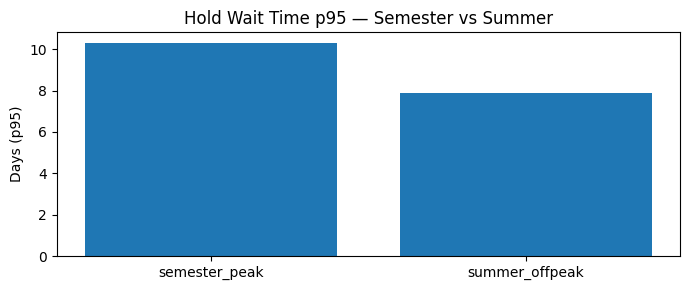

In [26]:
import os
os.makedirs("assets", exist_ok=True)

fig, ax = plt.subplots(figsize=(7,3))
ax.bar(season_kpi.index, season_kpi["p95"])
ax.set_title("Hold Wait Time p95 — Semester vs Summer")
ax.set_ylabel("Days (p95)")

fig.tight_layout()
fig.savefig("assets/hold_p95_semester_vs_summer.png", dpi=200, bbox_inches="tight")
plt.show()


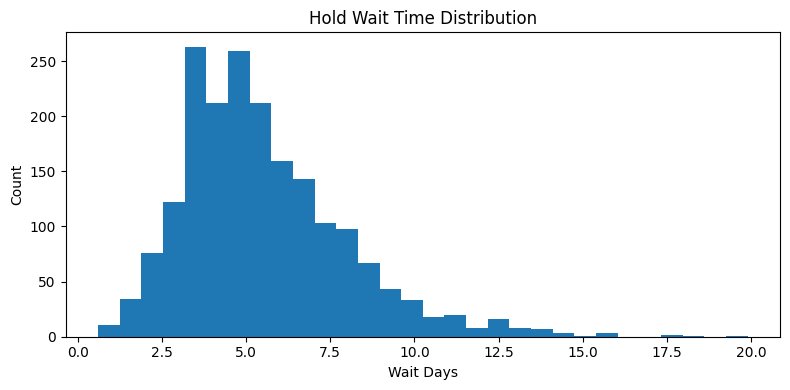

In [27]:
import os
os.makedirs("assets", exist_ok=True)

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(fulfilled["wait_days"], bins=30)
ax.set_title("Hold Wait Time Distribution")
ax.set_xlabel("Wait Days")
ax.set_ylabel("Count")

fig.tight_layout()
fig.savefig("assets/hold_wait_distribution.png", dpi=200, bbox_inches="tight")
plt.show()


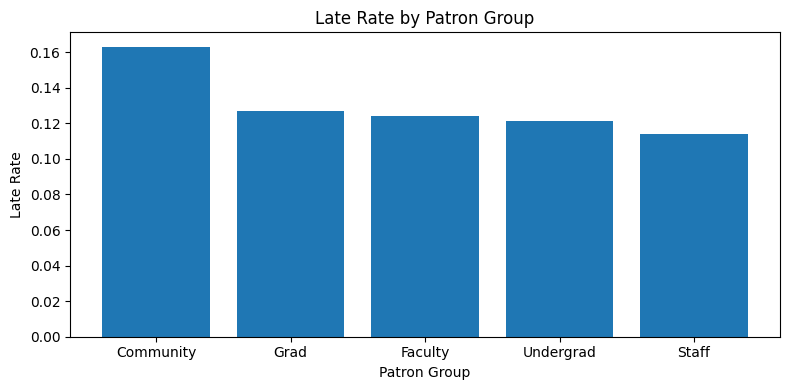

In [28]:
import os
os.makedirs("assets", exist_ok=True)

# make sure flags exist
txns["is_returned"] = txns["return_dt"].notna()
txns["is_late"] = txns["is_returned"] & (txns["return_dt"] > txns["due_dt"])

kpi_by_group = (txns
    .groupby("patron_group")
    .agg(late_rate=("is_late","mean"), transactions=("txn_id","count"))
    .reset_index()
).sort_values("late_rate", ascending=False)

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(kpi_by_group["patron_group"], kpi_by_group["late_rate"])
ax.set_title("Late Rate by Patron Group")
ax.set_xlabel("Patron Group")
ax.set_ylabel("Late Rate")

fig.tight_layout()
fig.savefig("assets/late_rate_by_patron_group.png", dpi=200, bbox_inches="tight")
plt.show()
